# Balance Log Explorer

Visualize the most recent balance attempts captured with `tools/balance_plot.py`. Compatible with both `motor_deg` (legacy) and `base_deg` (virtual encoder) logs.

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LOG_DIR = (Path('..') / 'logs').resolve()
LOG_DIR.mkdir(parents=True, exist_ok=True)
MAX_RECENT_ATTEMPTS = 5
print(f"Log directory: {LOG_DIR}")

Log directory: /Users/piyush/code/Rotary-Inverted-Pendulum/logs


In [2]:
# Import helper utilities from tools/balance_plot.py
import sys
from importlib import import_module

repo_root = Path.cwd()
if (repo_root / 'balance_plot.py').exists():
    sys.path.append(str(repo_root))
if (repo_root / 'tools' / 'balance_plot.py').exists():
    sys.path.append(str(repo_root / 'tools'))

balance_logger = import_module('balance_plot')
find_recent_logs = getattr(balance_logger, 'find_recent_logs')
load_log_dataframe = getattr(balance_logger, 'load_log_dataframe')

RECENT_LOGS = find_recent_logs(limit=MAX_RECENT_ATTEMPTS, directory=LOG_DIR)
print(f"Loaded {len(RECENT_LOGS)} log(s) (limit={MAX_RECENT_ATTEMPTS})")
RECENT_LOGS

Loaded 5 log(s) (limit=5)


[PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251119-161324_manual_0.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251119-161614_manual_0.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251119-161701_manual_0.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251119-161716_manual_0.csv'),
 PosixPath('/Users/piyush/code/Rotary-Inverted-Pendulum/logs/balance_20251119-161731_manual_0.csv')]

In [3]:
def select_base_column(df: pd.DataFrame) -> tuple[str | None, str]:
    if 'base_deg' in df.columns:
        return 'base_deg', 'Base Angle (deg)'
    if 'motor_deg' in df.columns:
        return 'motor_deg', 'Motor Angle (deg)'
    return None, ''


def plot_attempt(path: Path) -> None:
    df = load_log_dataframe(path)
    if df.empty:
        print(f"[WARN] {path.name} is empty; skipping plot")
        return

    fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

    axes[0].plot(df['time_s'], df['setpoint_deg'], label='Setpoint', color='C1', linewidth=1.2)
    axes[0].plot(df['time_s'], df['pendulum_deg'], label='Pendulum', color='C0', linewidth=1.2)
    axes[0].set_ylabel('Angle (deg)')
    axes[0].set_title(f'Pendulum Response — {path.name}')
    axes[0].legend(loc='upper right')

    # Plot base angle (motor position)
    base_col, base_label = select_base_column(df)
    if base_col and not df[base_col].isna().all():
        axes[1].plot(df['time_s'], df[base_col], label=base_label, color='C3')
    
    # Plot stepper steps if available (legacy logs)
    if 'stepper_steps' in df.columns:
        axes[1].plot(df['time_s'], df['stepper_steps'], label='Stepper Steps', color='C2', linestyle='--')

    axes[1].plot(df['time_s'], df['control_output'], label='Control Output', color='C4', linestyle=':')
    axes[1].set_ylabel('Position / Control')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_title('Base Feedback & Control Effort')
    axes[1].legend(loc='upper right')

    fig.tight_layout()
    plt.show()


def compute_metrics(df: pd.DataFrame, threshold_deg: float = 5.0) -> dict[str, float]:
    angles = df['pendulum_deg'].to_numpy()
    times = df['time_s'].to_numpy()
    metrics = {
        'peak_abs_deg': float(np.nanmax(np.abs(angles))) if angles.size else float('nan'),
        'samples': int(df.shape[0]),
    }
    settling_time = float('nan')
    if angles.size:
        for idx, t in enumerate(times):
            if np.all(np.abs(angles[idx:]) <= threshold_deg):
                settling_time = float(t - times[0])
                break
    metrics['settling_time_s'] = settling_time
    return metrics

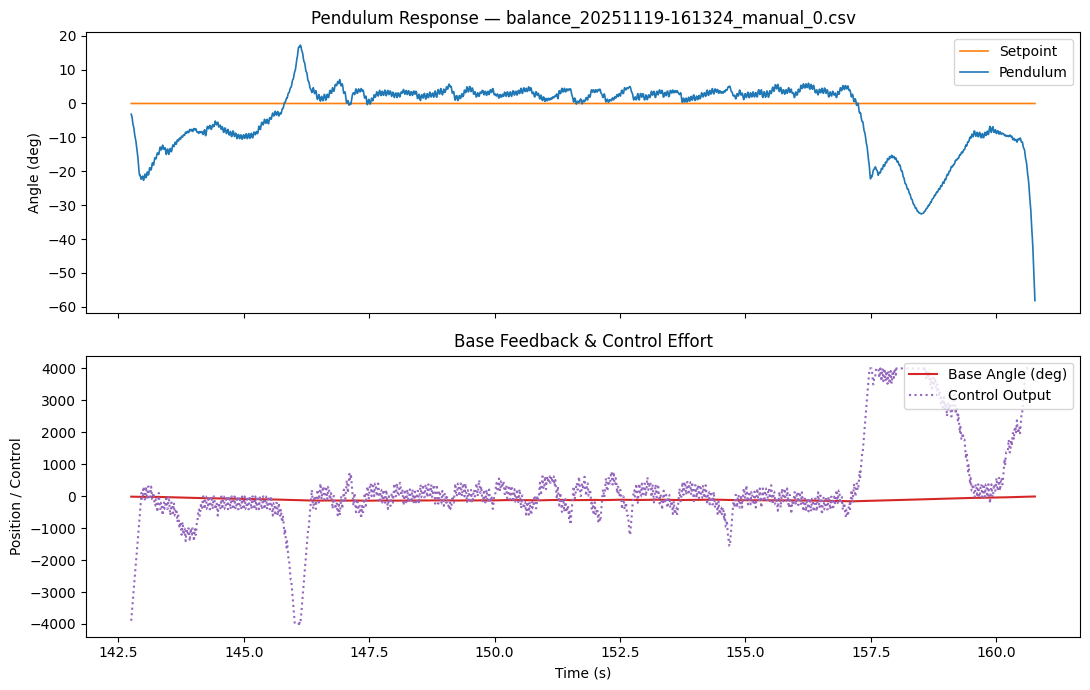

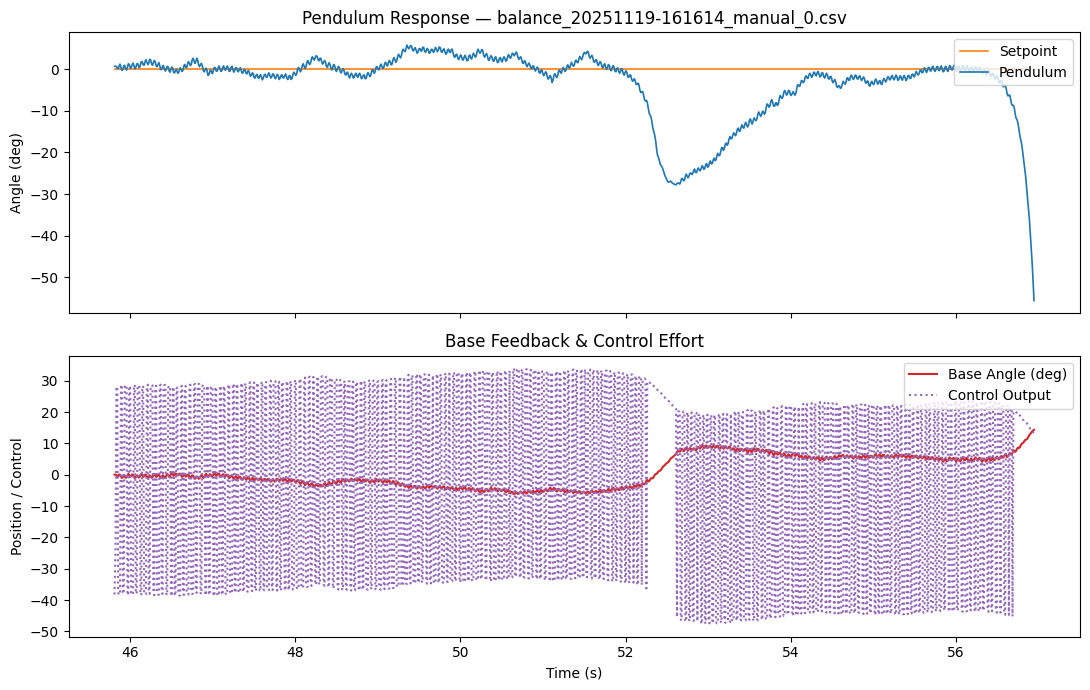

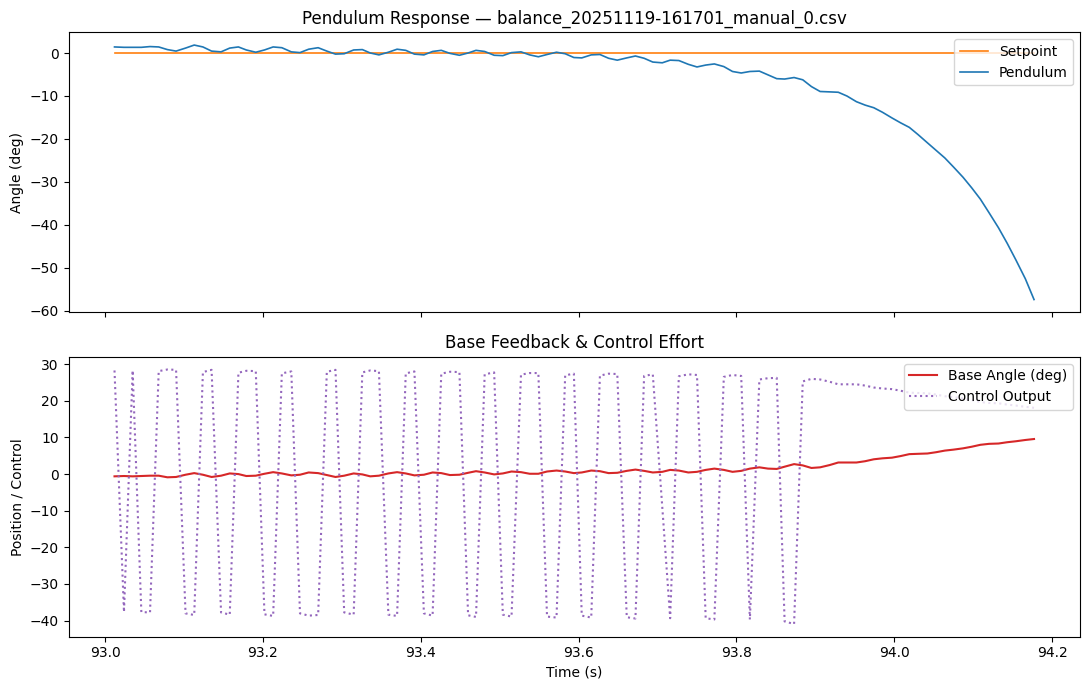

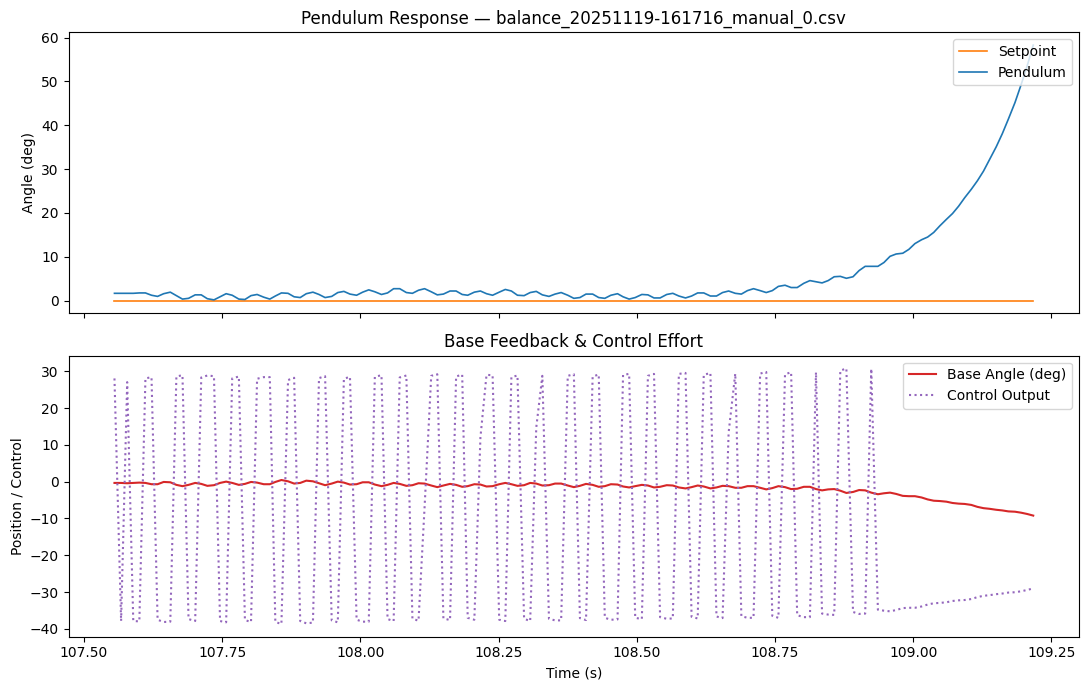

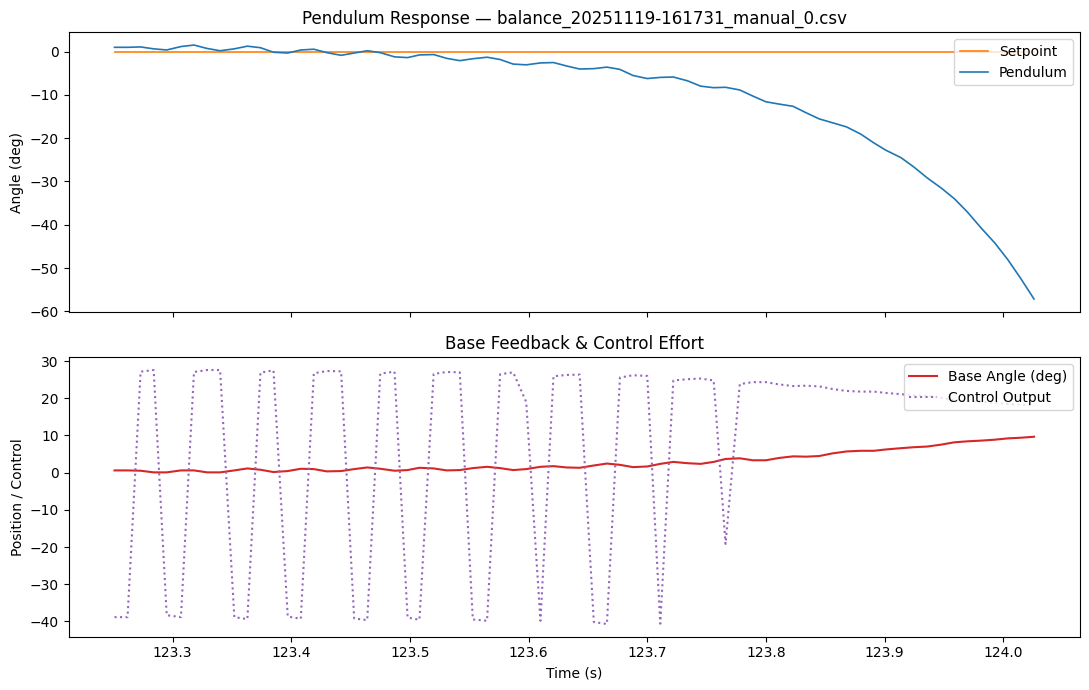

In [4]:
if not RECENT_LOGS:
    print('[INFO] No logs yet. Run tools/balance_plot.py to capture sessions.')
else:
    for path in RECENT_LOGS:
        plot_attempt(path)

In [5]:
summary_records: List[dict[str, float | str]] = []
if RECENT_LOGS:
    for path in RECENT_LOGS:
        df = load_log_dataframe(path)
        if df.empty:
            continue
        metrics = compute_metrics(df)
        metrics['file'] = path.name
        summary_records.append(metrics)

metrics_df = pd.DataFrame(summary_records)
metrics_df

,peak_abs_deg,samples,settling_time_s,file
0,58.181,1762,NaN,balance_20251119-161324_manual_0.csv
1,55.632,994,NaN,balance_20251119-161614_manual_0.csv
2,57.390,105,NaN,balance_20251119-161701_manual_0.csv
3,58.274,149,NaN,balance_20251119-161716_manual_0.csv
4,57.126,70,NaN,balance_20251119-161731_manual_0.csv


In [6]:
def extract_gain_summary(paths: Iterable[Path]) -> pd.DataFrame:
    rows = []
    for path in paths:
        df = load_log_dataframe(path)
        if df.empty:
            continue
        sample = df.iloc[0]
        rows.append({
            'file': path.name,
            'kp': float(sample['kp_balance']),
            'ki': float(sample['ki_balance']),
            'kd': float(sample['kd_balance']),
            'km': float(sample['kp_motor']),
            'origin': sample['origin'],
            'reason': sample['reason'],
            'session_id': int(sample['session_id']),
            'device_ms': int(sample['device_start_ms']),
            'timestamp': sample['host_start_iso']
        })
    return pd.DataFrame(rows)

GAIN_TABLE = extract_gain_summary(RECENT_LOGS)
GAIN_TABLE

,file,kp,ki,kd,km,origin,reason,session_id,device_ms,timestamp
0,balance_20251119-161324_manual_0.csv,-35.0,-0.2,-6.0,0.3,manual,0,3,142748,2025-11-19T10:43:24.673430+00:00
1,balance_20251119-161614_manual_0.csv,-35.0,-0.2,-6.0,0.3,manual,0,1,45806,2025-11-19T10:46:14.321737+00:00
2,balance_20251119-161701_manual_0.csv,-35.0,-0.2,-6.0,0.3,manual,0,2,93003,2025-11-19T10:47:01.554973+00:00
3,balance_20251119-161716_manual_0.csv,-35.0,-0.2,-6.0,0.3,manual,0,3,107546,2025-11-19T10:47:16.111473+00:00
4,balance_20251119-161731_manual_0.csv,-35.0,-0.2,-6.0,0.3,manual,0,4,123241,2025-11-19T10:47:31.818963+00:00


### balance_20251119-161731_manual_0.csv- Session ID: 4 (device ms: 123241)- Timestamp: 2025-11-19T10:47:31.818963+00:00- Origin: `manual` → Reason: `0`- Gains: Kp = -35.0000, Ki = -0.2000, Kd = -6.0000, Km = 0.3000

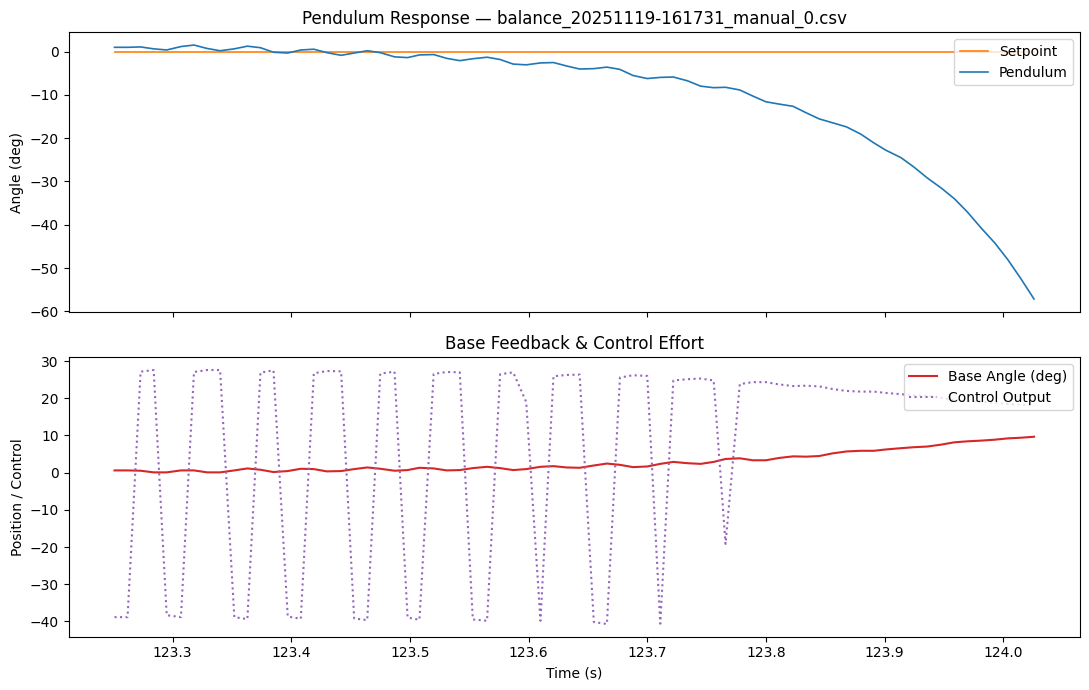

### balance_20251119-161716_manual_0.csv- Session ID: 3 (device ms: 107546)- Timestamp: 2025-11-19T10:47:16.111473+00:00- Origin: `manual` → Reason: `0`- Gains: Kp = -35.0000, Ki = -0.2000, Kd = -6.0000, Km = 0.3000

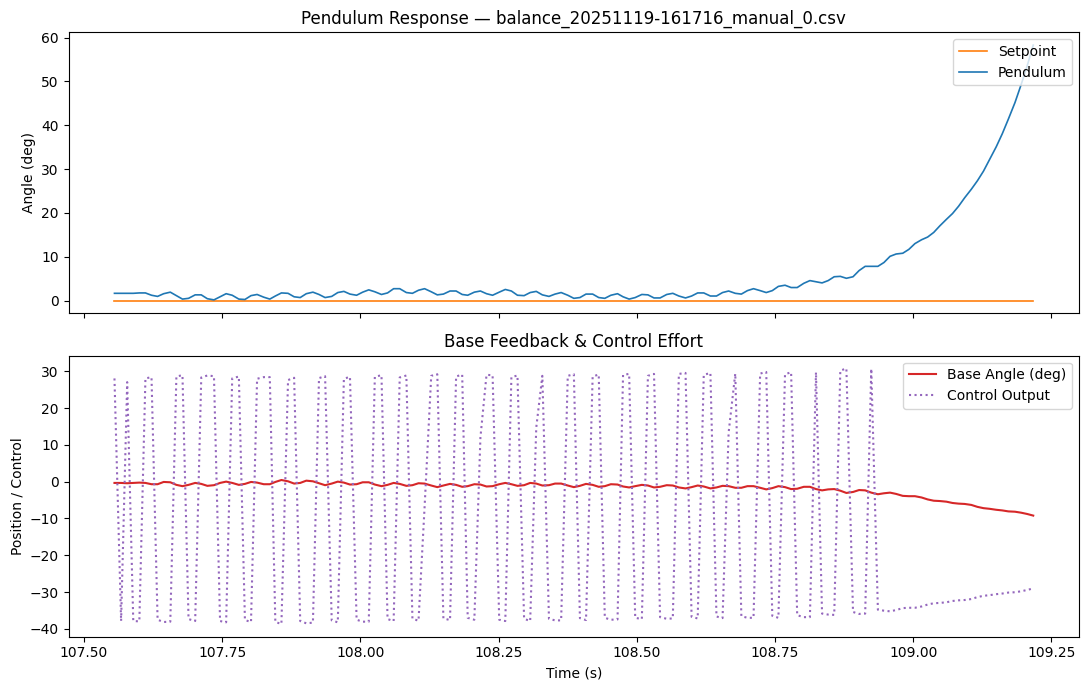

### balance_20251119-161701_manual_0.csv- Session ID: 2 (device ms: 93003)- Timestamp: 2025-11-19T10:47:01.554973+00:00- Origin: `manual` → Reason: `0`- Gains: Kp = -35.0000, Ki = -0.2000, Kd = -6.0000, Km = 0.3000

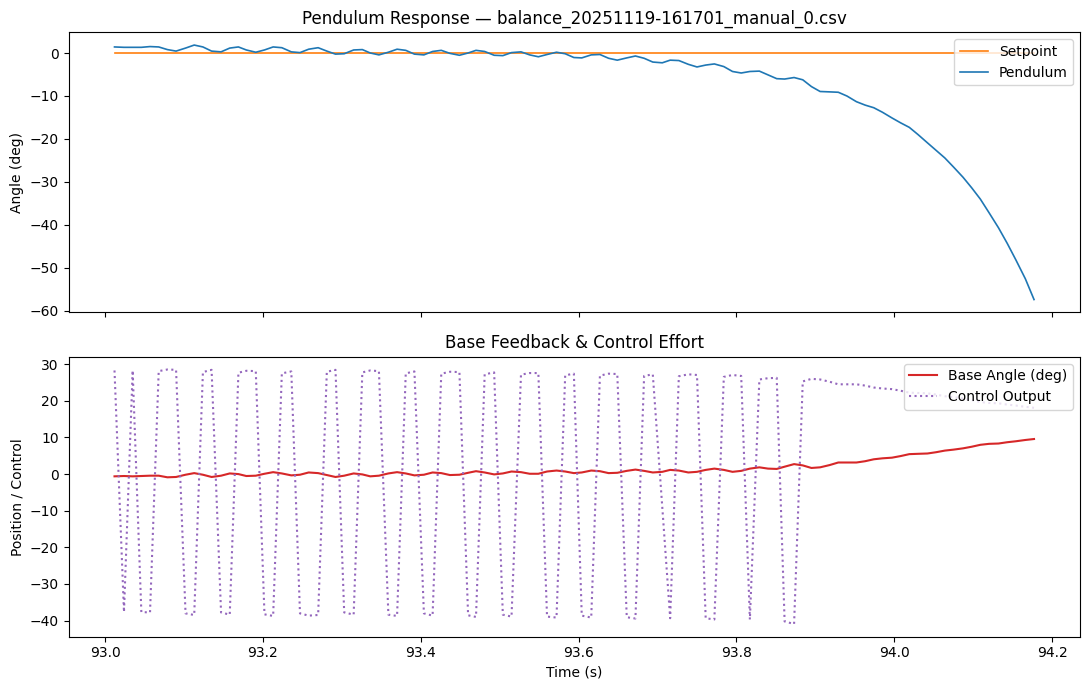

### balance_20251119-161614_manual_0.csv- Session ID: 1 (device ms: 45806)- Timestamp: 2025-11-19T10:46:14.321737+00:00- Origin: `manual` → Reason: `0`- Gains: Kp = -35.0000, Ki = -0.2000, Kd = -6.0000, Km = 0.3000

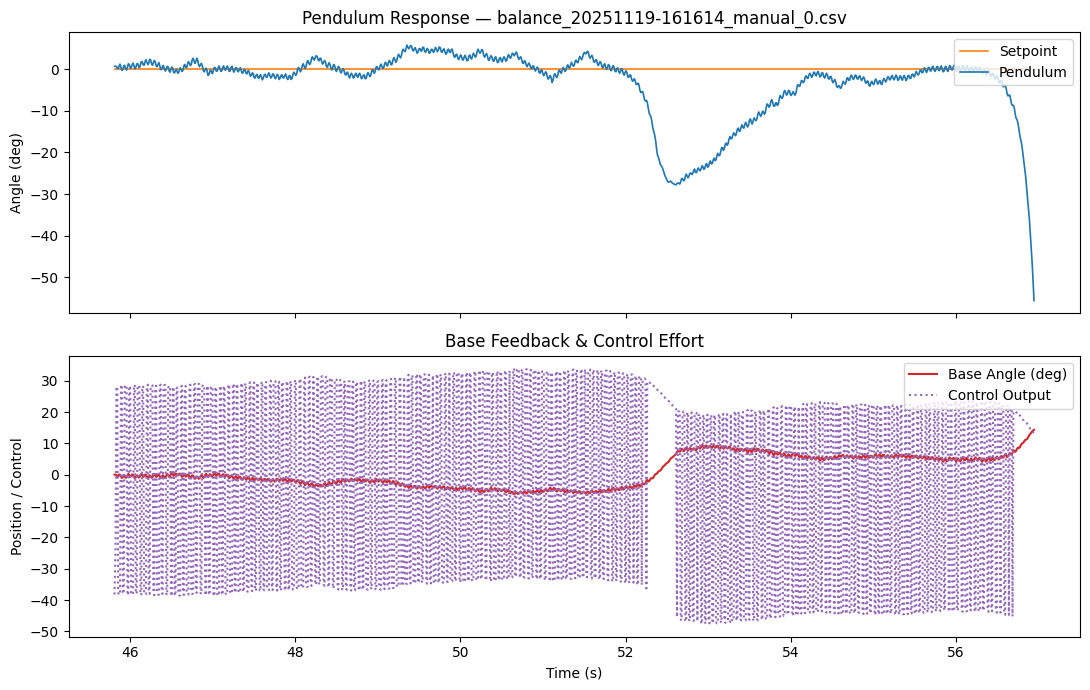

### balance_20251119-161324_manual_0.csv- Session ID: 3 (device ms: 142748)- Timestamp: 2025-11-19T10:43:24.673430+00:00- Origin: `manual` → Reason: `0`- Gains: Kp = -35.0000, Ki = -0.2000, Kd = -6.0000, Km = 0.3000

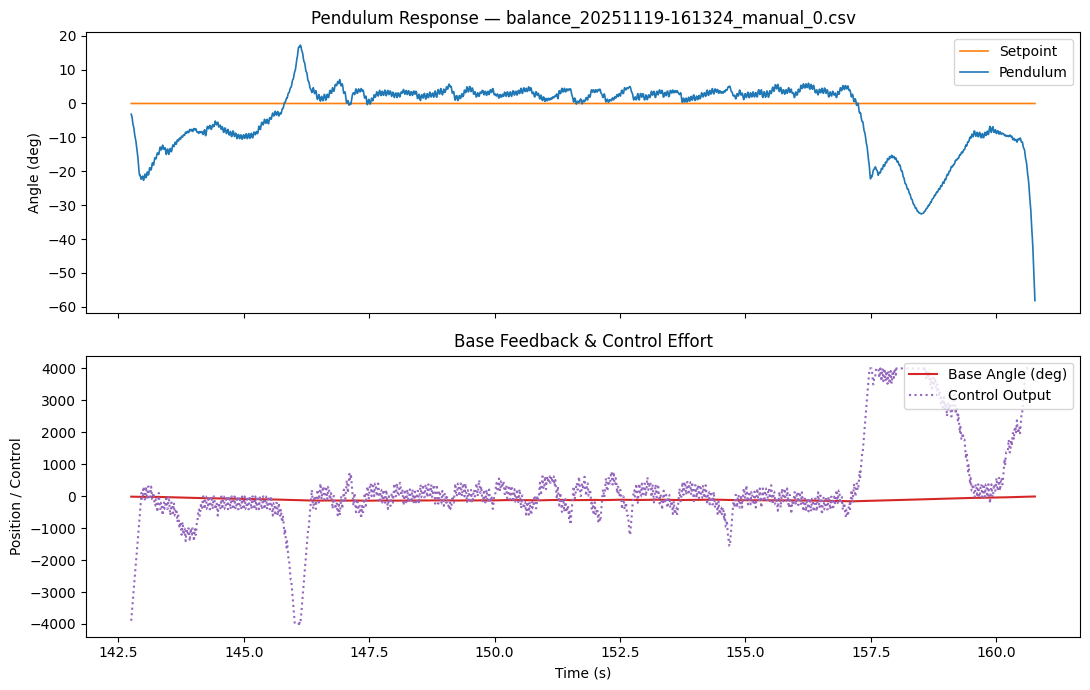

In [7]:
from IPython.display import Markdown, display

if not RECENT_LOGS:
    display(Markdown(f"**No log files found in** `{LOG_DIR}`."))
else:
    for path in RECENT_LOGS[::-1]:
        df = load_log_dataframe(path)
        if df.empty:
            continue
        gains = df.loc[0, ['kp_balance','ki_balance','kd_balance','kp_motor']].astype(float)
        origin = df.loc[0, 'origin']
        reason = df.loc[0, 'reason']
        session_id = int(df.loc[0, 'session_id'])
        device_ms = int(df.loc[0, 'device_start_ms'])
        timestamp = df.loc[0, 'host_start_iso']
        header = '\n'.join([
            f"### {path.name}"
            f"- Session ID: {session_id} (device ms: {device_ms})"
            f"- Timestamp: {timestamp}"
            f"- Origin: `{origin}` → Reason: `{reason}`"
            f"- Gains: Kp = {gains['kp_balance']:.4f}, Ki = {gains['ki_balance']:.4f}, Kd = {gains['kd_balance']:.4f}, Km = {gains['kp_motor']:.4f}"
        ])
        display(Markdown(header))
        plot_attempt(path)


### Helper: integrate per-tick control deltas

Firmware now logs control as per-tick deltas in steps (column: `control_delta_steps`). Use the helper below to integrate this into a control position-like series for comparison with older logs that used absolute control outputs.

In [8]:
from typing import Optional
import numpy as np
import pandas as pd

def integrate_control_delta(df: pd.DataFrame, start: Optional[float] = None, out_col: str = 'control_abs_steps') -> pd.DataFrame:
    """
    If the DataFrame contains `control_delta_steps`, add an integrated column (default name: `control_abs_steps`).
    By default, the integration starts at the first `stepper_steps` value if present; otherwise starts at 0.
    The function returns the original DataFrame with the new column added (no copy).
    """
    if 'control_delta_steps' not in df.columns:
        # Nothing to do; return as-is
        return df

    if start is None:
        start = float(df['stepper_steps'].iloc[0]) if 'stepper_steps' in df.columns and len(df) else 0.0

    deltas = df['control_delta_steps'].to_numpy(dtype=float)
    integ = np.cumsum(deltas) + float(start)
    df[out_col] = integ
    return df

# Example usage on the most recent log (if any):
if RECENT_LOGS:
    _df = load_log_dataframe(RECENT_LOGS[0])
    integrate_control_delta(_df)
    display(_df.head())

,time_s,setpoint_deg,pendulum_deg,base_deg,pendulum_vel,base_vel,control_output,kp_balance,ki_balance,kd_balance,kp_motor,origin,reason,session_id,device_start_ms,host_start_iso
0,142.758,0.0,-3.161,-15.318,-3251.953,-15318.280,-3900.0,-35.0,-0.2,-6.0,0.3,manual,0,3,142748,2025-11-19T10:43:24.673430+00:00
1,142.769,0.0,-3.689,-15.782,-175.781,-232.096,-3700.0,-35.0,-0.2,-6.0,0.3,manual,0,3,142748,2025-11-19T10:43:24.673430+00:00
2,142.779,0.0,-4.480,-16.247,-527.344,-232.094,-3500.0,-35.0,-0.2,-6.0,0.3,manual,0,3,142748,2025-11-19T10:43:24.673430+00:00
3,142.789,0.0,-5.710,-16.711,-615.234,-232.096,-3300.0,-35.0,-0.2,-6.0,0.3,manual,0,3,142748,2025-11-19T10:43:24.673430+00:00
4,142.799,0.0,-6.501,-17.175,-351.562,-232.096,-3100.0,-35.0,-0.2,-6.0,0.3,manual,0,3,142748,2025-11-19T10:43:24.673430+00:00
